In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import os
print(os.getcwd())
os.chdir("../")

/Users/pandhari/Desktop/Coffee_Shop_ChatBot/Python_Backend/Backend/experiments


In [3]:
import os
print(os.getcwd())
os.chdir("../")

/Users/pandhari/Desktop/Coffee_Shop_ChatBot/Python_Backend/Backend


In [4]:
print(os.getcwd())

/Users/pandhari/Desktop/Coffee_Shop_ChatBot/Python_Backend


In [5]:
from Backend.graph.coffee_shop_graph import build_coffee_shop_graph
build = build_coffee_shop_graph()

/opt/anaconda3/envs/ai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


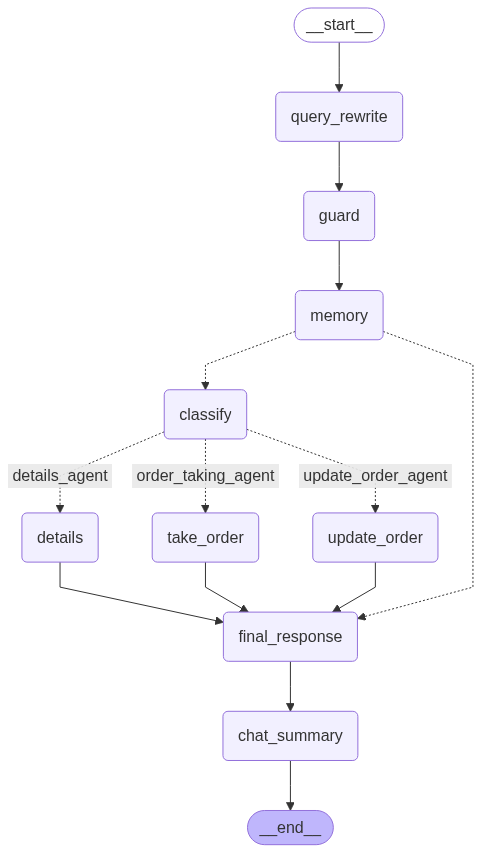

In [6]:
from IPython.display import Image , display
display(Image(build.get_graph(xray=True).draw_mermaid_png()))

In [7]:
from App.chatbot import get_bot_response

In [8]:
print(get_bot_response(user_input="tell me about your Latte" , user_id=15))


Starting get_user_memory
Done get_user_memory
Starting get_summary
Done get_summary
Starting get_messages
Done get_messages
Starting get_order
Started Get Order
Done get_order


I0000 00:00:1755459504.373058  136530 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


content='tell me about your Latte' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 7, 'prompt_tokens': 2386, 'total_tokens': 2393, 'completion_time': 0.009115557, 'prompt_time': 0.185811273, 'queue_time': 0.045375138, 'total_time': 0.19492683}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'finish_reason': 'stop', 'logprobs': None} id='run--e1a64fee-fe3a-46bb-83e6-8fd297ced989-0' usage_metadata={'input_tokens': 2386, 'output_tokens': 7, 'total_tokens': 2393}
Retrieved 3 docs.
Retrieved 3 docs.
Saving Order
Started Serializing Order
{'response': "Hi Pratik! I'm really glad you're interested in our **Latte**! It's a smooth and creamy delight that combines rich espresso with velvety steamed milk, creating that perfect balance of flavor and texture. You can enjoy it as a comforting treat any time of day, whether you’re just starting your morning or taking a midday break.\n\nHere are the details:\n- **Price:** $4.75\n- **Rating:

In [2]:
!pip show langchain_groq

Name: langchain-groq
Version: 0.3.2
Summary: An integration package connecting Groq and LangChain
Home-page: 
Author: 
Author-email: 
License: MIT
Location: /opt/anaconda3/envs/ai/lib/python3.10/site-packages
Requires: groq, langchain-core
Required-by: 


In [ ]:

from Backend.utils.memory_manager import get_user_memory
from Backend.utils.summary_memory import get_summary , get_messages , get_order

graph = build_coffee_shop_graph() 

In [ ]:
import asyncio
import json
from rich import print

async def test_graph_stream(user_input: str, user_id: int):
    state = {
        "user_memory": None,
        "messages": [],
        "chat_summary": "",
        "user_input": "",
        "response_message": None,
        "decision": None,
        "target_agent": None,
        "order": [],
        "final_price": None,
        "memory_node": False,
    }

    state["user_input"] = user_input
    state["user_memory"] = get_user_memory(user_id)
    state["chat_summary"] = get_summary(id=user_id)
    state["messages"] = get_messages(id=user_id)
    state["order"], state["final_price"] = get_order(id=user_id)

    config = {
        "configurable": {
            "user_id": user_id
        }
    }

    print("[bold green]🚀 Starting graph stream...[/bold green]\n")

    async for event in graph.astream(state, config=config):
        if "node" in event:
            node = event["node"]
            print(f"[bold blue]🔧 Node running: {node}[/bold blue]")
        if "at" in event:
            print(f"[dim]🕒 {event['at']}[/dim]")

    print("\n✅ [bold green]Done.[/bold green]")

# Run it
await test_graph_stream("I want to order it", user_id=123)

In [3]:
from typing import List, Callable, Optional, Type
from pydantic import BaseModel

def call_with_fallback(
    model_factories: List[Callable],
    prompt: str,
    schema: Optional[Type[BaseModel]] = None,
    temperature: float = 0.0,
):
    """
    Call multiple LLMs in fallback order.
    Supports both simple and structured outputs.
    
    Args:
        model_factories: List of model factory callables (lambda **kw: LLM(...))
        prompt: User input or task instruction
        schema: Optional Pydantic model for structured output
        temperature: Sampling temperature for all LLMs
    
    Returns:
        LLM response (str if schema=None, else schema instance)
    """
    last_error = None
    
    for factory in model_factories:
        try:
            llm = factory(temperature=temperature)
            
            if schema:
                # Structured output case
                structured_llm = llm.with_structured_output(schema)
                return structured_llm.invoke(prompt)
            else:
                # Simple output case
                return llm.invoke(prompt)
                
        except Exception as e:
            print(f"⚠️ {factory.__name__} failed: {e}")
            last_error = e
            continue
    
    raise RuntimeError(f"All models failed. Last error: {last_error}")